/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[0.         0.19191919 0.2020202  0.7979798 ]
[0.         0.19946093 0.2001243  0.79049099]


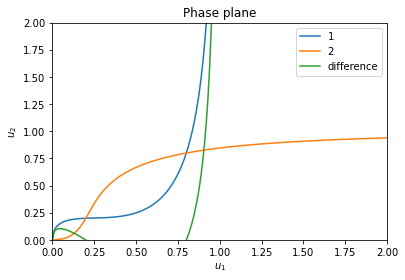

In [178]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import newton 
from tqdm import tqdm 

def F(u,o):
    f = u**2/(u**2+o**2)
    return f

def G(v,o):
    g = o*np.sqrt(v/(1-v))
    return g

w11,w22,w12,w21,o = 0.3,0.2,0.2,0.3,0.2

u1_null1 = np.linspace(0,1,100)
u2_null1 = (G(u1_null1,o)-w11*u1_null1)/w12

u2_null2 = np.linspace(0,1,100)
u1_null2 = (G(u2_null2,o)-w22*u2_null2)/w21

fig,ax = plt.subplots()
ax.plot(u1_null1,u2_null1,label='1')
ax.plot(u1_null2,u2_null2,label='2')
ax.plot(u1_null1,u2_null1-u2_null2,label='difference')
ax.set_xlim([0,2])
ax.set_ylim([0,2])
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_title('Phase plane')
ax.legend()


print(u1_null1[np.where(np.abs(u2_null1-u2_null2)<10**-2)])
print(u2_null1[np.where(np.abs(u2_null1-u2_null2)<10**-2)])

